In [1]:
%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from astropy.cosmology import Planck15 as cosmo
from astropy.table import Table
# from archivalCGMtools.loc4 import slime
#from goodies import closest
from mpl_toolkits import mplot3d
from astropy import stats as astats
%matplotlib inline
import pickle

from pyslime import slime
from pyslime import utils as psu

from scipy import stats

from pyslime.pipeline import interpolate, catalogs

pipedatadir = "/Users/mwilde/python/pyslime/pyslime/pipeline/data/"

In [2]:
mapping_data_pickle_file = "/Users/mwilde/python/pyslime/pyslime/pipeline/data/mapping_BP_z0p0_1sigma.pick"
smpackage = pickle.load(open(mapping_data_pickle_file,'rb'))

In [3]:
err_lo = smpackage['loperc_bp']
err_hi = smpackage['hiperc_bp']
smpackage.keys()

dict_keys(['medvals_bp', 'meanvals_bp', 'loperc_bp', 'hiperc_bp', 'bpdistribs_sm', 'smdistribs_sm', 'smrhobins'])

In [4]:
smrhobins = smpackage['smrhobins']
binsize = 0.1
midbins = 0.5*smrhobins[:-1]+ 0.5*smrhobins[1:]

# The first and last bins have 0 counts, don't include them

In [5]:
nonan = ~np.isnan(smpackage['medvals_bp'])

In [6]:
from scipy.interpolate import InterpolatedUnivariateSpline

mapfunc = InterpolatedUnivariateSpline(midbins[nonan], smpackage['medvals_bp'][nonan], k=1)

In [7]:
from scipy.interpolate import interp1d
mapfunc1d = interp1d(midbins[nonan], smpackage['medvals_bp'][nonan])

In [8]:
mapfunc1d


In [9]:
smdens, bpdens = midbins[nonan], smpackage['medvals_bp'][nonan]
err_lo = smpackage['loperc_bp'][nonan]
err_hi = smpackage['hiperc_bp'][nonan]

In [10]:
def find_xbreak(smdens, bpdens, plot=False):
    break_cut = (smdens > 0) & (smdens < 2)
    xmiddiff = 0.5*smdens[break_cut][1:] + 0.5*smdens[break_cut][:-1]
    diff = np.diff(bpdens[break_cut])
    xbreak = xmiddiff[np.argmax(diff)]
    if plot:
        plt.plot(xmiddiff, diff)
        plt.axvline(xbreak)
    return xbreak
    


In [11]:
smdens, bpdens = midbins[nonan], smpackage['medvals_bp'][nonan]


# find where the break is
x = np.linspace(0, 2)
xbreak = find_xbreak(smdens, bpdens)
print(xbreak)

# find what the constant y value below this break is
y_const = np.mean(bpdens[smdens < xbreak])
print(y_const)

# constrain where to do the linear fitting
lin_cut = (smdens > xbreak-0.5)

# 
xfit = smdens[lin_cut]
yfit = bpdens[lin_cut]
slope, intercept, r_value, p_value, std_err = stats.linregress(xfit, yfit)
z = np.polyfit(xfit, yfit, 3)
pfit = np.poly1d(z)






def linmap(smdens, xbreak, y_const, slope, intercept):
    y_lin = slope * smdens + intercept
    y = np.where(smdens < xbreak, y_const, y_lin)
    
    return y

def rectified(x, y_const):
    y = slope * x + intercept
    return np.maximum(y_const, y)

def rectifiedp3(x):
    y_const = np.mean(bpdens[smdens < xbreak])
    xfit = smdens[lin_cut]
    yfit = bpdens[lin_cut]
    z = np.polyfit(xfit, yfit, 3)
    pfit = np.poly1d(z)

    y = np.where(x < xbreak-0.3, y_const, pfit(x))
    return np.maximum(y_const, y)

        

0.700886893272402
-0.6805904600886951


In [12]:
z, xbreak, y_const

(array([-0.03472536,  0.37368174,  0.11105251, -0.75538756]),
 0.700886893272402,
 -0.6805904600886951)

In [13]:
mapfunck5 = InterpolatedUnivariateSpline(midbins[nonan], smpackage['medvals_bp'][nonan], k=1)

import scipy
spline = scipy.interpolate.UnivariateSpline(midbins[nonan], smpackage['medvals_bp'][nonan], k=1, s=0.000001)

In [14]:
spline

In [16]:
from scipy import stats

xfull = np.linspace(-1, 4, 50)
plt.scatter(smdens, bpdens, s=1)
plt.fill_between(smdens, y1=err_lo, y2=err_hi, alpha=0.3)
# plt.plot(xfull, mapfunck5(xfull), label='spline')

# plt.plot(xfull, mapfunc(xfull), label='spline')
# plt.plot(xfull, spline(xfull))
# plt.plot(xfit, pfit(xfit))
# plt.plot(xfull, mapfunc1d(xfull), label='interp1d')
# plt.plot(xfull, linmap(xfull, xbreak, y_const, slope, intercept), label='lin');
# plt.plot(xfull, rectified(xfull, y_const), label='lin');
plt.plot(xfull, rectifiedp3(xfull, y_const, label='lin');
# plt.plot(midbins, terpSlimeBp(midbins), label='interp')
# plt.scatter(midbins, smpackage['medvals_bp'])

SyntaxError: invalid syntax (<ipython-input-16-21302e3a65fe>, line 14)

In [ ]:
# check that this mapping gets something reasonable for a coma like density
# this number comes from the standardize_sdss notebook/rerouting-to-data notebook
3.96
mapfunc(3.6)

array(2.92216937)

# test on a gaussian

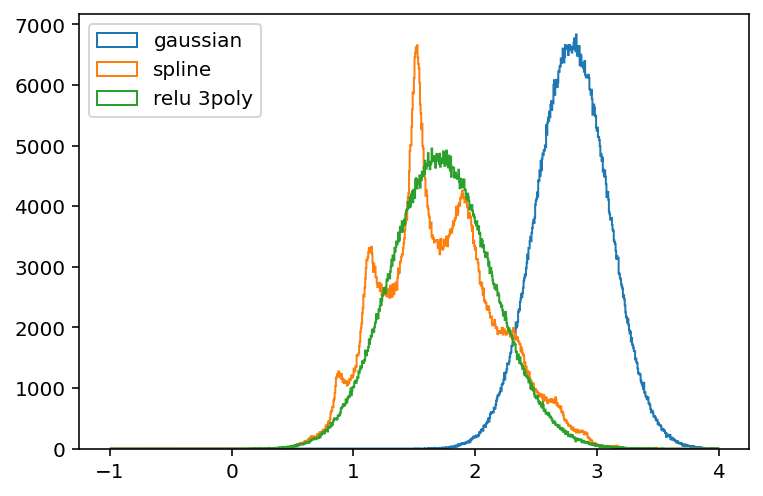

In [ ]:
g = np.random.normal(2.8, 0.3, 1000000)

bins = np.linspace(-1,4, 1000)
kwargs = {}
kwargs['bins'] = bins
kwargs['histtype'] = 'step'

spline = scipy.interpolate.UnivariateSpline(midbins[nonan], smpackage['medvals_bp'][nonan], k=5, s=1e-9)

plt.hist(g, **kwargs, label='gaussian');
plt.hist(spline(g), **kwargs, label='spline');
plt.hist(rectifiedp3(g), **kwargs, label='relu 3poly')
plt.legend(loc='upper left')

plt.show()

# below, I am investigating using linear fit but the above mapping seams to work well. 

In [ ]:
mapping_data_pickle_file = "/Users/mwilde/python/pyslime/pyslime/pipeline/data/mapping_BP_z0p5_1sigma.pick"
smpackage = pickle.load(open(mapping_data_pickle_file,'rb'))
smdens, bpdens = interpolate.slurp_data(mapping_data_pickle_file)

# constrain where to do the fitting: only past the break
xbreak = find_xbreak(smdens, bpdens)
lin_cut = smdens > xbreak - 0.5

xfit = smdens[lin_cut]
yfit = bpdens[lin_cut]

err_lo = smpackage['loperc_bp'][nonan]
err_hi = smpackage['hiperc_bp'][nonan]

xbreak = interpolate.find_xbreak(smdens, bpdens)
y_const = interpolate.find_y_const(smdens, bpdens, xbreak)
lin_cut = smdens > xbreak - 0.5
xfit = smdens[lin_cut]
yfit = bpdens[lin_cut]

z = np.polyfit(xfit, yfit, 3)
pfit = np.poly1d(z)

outdict = {}
outdict["xbreak"] = xbreak
outdict["y_const"] = y_const
outdict["pfit"] = pfit

mapfunc = interpolate.relu_p3(x, xbreak, y_const, pfit)

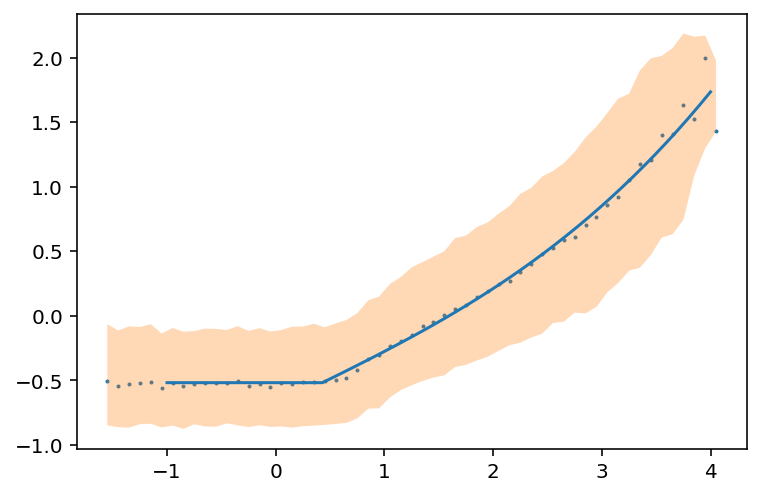

In [ ]:
xfull = np.linspace(-1, 4, 50)
plt.scatter(smdens, bpdens, s=1)
plt.fill_between(smdens, y1=err_lo, y2=err_hi, alpha=0.3)
# plt.plot(xfull, mapfunck5(xfull), label='spline')

# plt.plot(xfull, mapfunc(xfull), label='spline')
# plt.plot(xfull, spline(xfull))
plt.plot(xfull, interpolate.relu_p3(xfull, xbreak, y_const, pfit))
# plt.plot(xfull, mapfunc1d(xfull), label='interp1d')
# plt.plot(xfull, linmap(xfull, xbreak, y_const, slope, intercept), label='lin');#

In [ ]:
xbreak0, y_const0, pfit0, xbreak5, y_const5, pfit5 = catalogs.load_mapfuncs(pipedatadir)

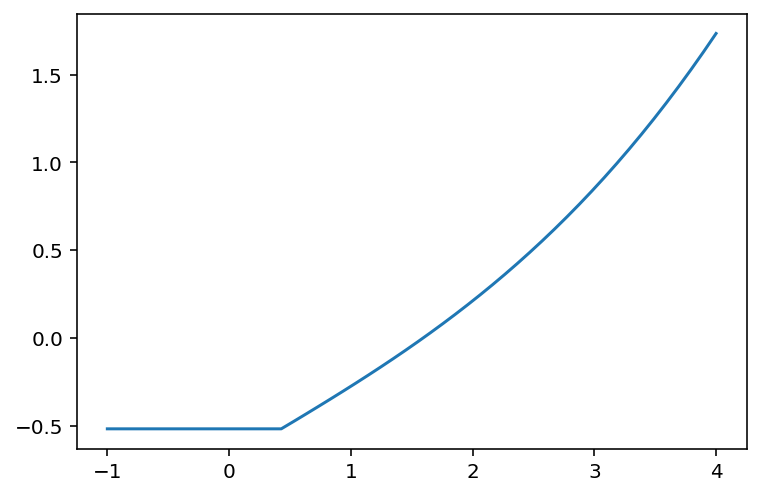

In [ ]:
g = np.random.normal(2.8, 0.3, 1000000)
plt.plot(xfull, interpolate.relu_p3(xfull, xbreak5, y_const5, pfit5))

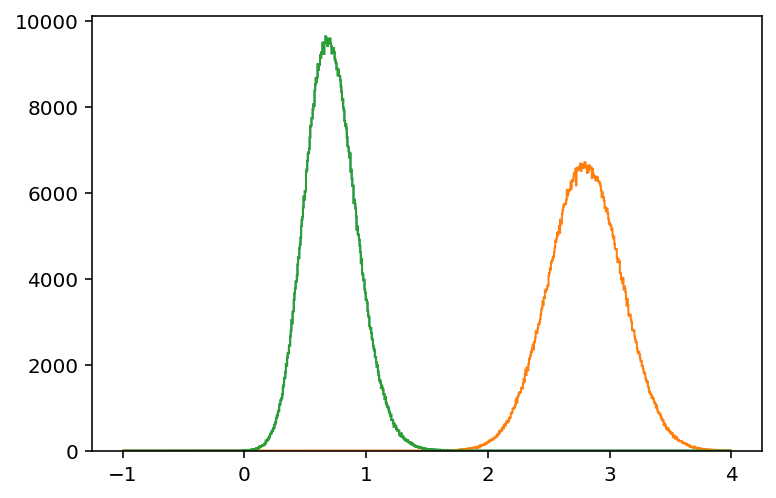

In [ ]:

g = np.random.normal(2.8, 0.3, 1000000)
plt.hist(interpolate.relu_p3(g, xbreak5, y_const5, pfit5), **kwargs)
plt.hist(g, **kwargs);
plt.hist(interpolate.relu_p3(g, xbreak, y_const, pfit), **kwargs);

In [ ]:
mapfunc(3.53)

array(2.84366695)

In [ ]:
mapfunc(3.4574211329533497)

array(2.7562127)

In [ ]:
10**2.67838699

476.85571289667365